# Homework 3 - Hidden Markov Model

Pierre-Louis Guhur pierre-louis.guhur@ens-paris-saclay.fr


## Model
The notations are adapted from (C.M. Bishop, 2009). 

We observe data of the form $u_t = (x_t, y_t) \in \mathbb{R}^2$ for $t\in 1,...,T$.

We consider an HMM with a linear chain $(q_t)$ with $K=4$ states of the transition matrix $a \in \mathbb{R}^{4\times4}$, and Gaussian “emission probabilities”: $u_t|q_t = k \sim \mathcal{N}(\mu_k, \Sigma_k)$.

Elements $a_{j,k}$ from the transition matrix are called the transition probability from state $j$ to state $k$: $a_{j,k} = p(q_{t,k}=1 | q_{t-1,j}=1)$.

The joint distribution of $U$ and $Q$ is given by 

$$
\begin{align}
    p\left( U, Q \middle| \theta \right) = 
    p\left( q_1 \middle| (\pi_k)_k \right)
    \left[ \prod_{t=2}^{T} p\left( q_t \middle| q_{t-1} , a\right) \right]
    \left[ \prod_{t=1}^{T}  p\left( u_t \middle| q_t, \phi \right) \right]
\end{align}
$$

where

$$
\begin{align}
    \theta &= \left( \pi, a, (\mu_k)_k, (\Sigma_k)_k \right) \\
    p\left( q_1 \middle| \pi \right) &= \prod_{k=0}^{K-1} \pi_{k}^{q_{1,k}}  \\
    p\left( q_n \middle| q_{t-1}, a \right) &=  \prod_{k=0}^{K-1} \prod_{j=0}^{K-1} a_{j,k} ^{q_{t-1,j} q_{t,k}} \\
    p\left( u_t \middle| q_t, \theta \right) &= \prod_{k=0}^{K-1} p(u_t | \mu_k, \Sigma_k)^{q_{t,k}} = \prod_{k=0}^{K-1} \frac{1}{2\pi\det\Sigma} \exp \left[ (u_t-\mu_k)^T \Sigma^{-1} (u_t-\mu_k) \right]^{q_{t,k}}
\end{align}
$$

## EM Algorithm

$\theta$ is computed such that the likelihood is maximized:
$$
L(U, \theta) = p(U|\theta) = \sum_{Q} p(U,Q|\theta)
$$
Because here we have a latent variable $Q$, we can utilise EM algorithm to perform the maximization:

0. input : $\theta_{ini}$, $X$.
1. $\theta^{old} \leftarrow \theta_{ini}$
2. while not converge
    1. E-step : Calculate $loss(\theta, \theta^{old}) := \sum_{Q} p \left( Q \middle| U,\theta^{old} \right) \log p(U,Q|\theta)$ as a function of $\theta$
    2. M-step : Let $\theta_M$ be $\theta$ that maximizes $loss(\theta, \theta^{old})$, and set $\theta^{old} \leftarrow \theta_M$

We introduce:
- the function to maximize $loss(\theta, \theta^{old})$,
- $\gamma_{t,k} = p(q_{t,k}=1 | U, \theta^{old})$,
- $\xi_{t,j,k} = p(q_{t-1,j}=1 , q_{t,k}=1 | U, \theta^{old})$
    
We have:

$$
loss(\theta, \theta^{old}) = 
\sum_{k=0}^{K-1} \gamma_{0,k} \log \pi_k
 + \sum_{t=1}^{T} \sum_{j,k=0}^{K-1} \xi_{t,j,k} \log a_{j,k} 
 + \sum_{t=1}^{T} \sum_{k=0}^{K-1} \gamma_{t,k} \log p(u_t | \mu_k,\Sigma_k) 
$$

The quantities $\gamma$ and $\xi$ followed from:

$$
\begin{align}
    \gamma_{t,k} &=  \alpha_{t,k} \beta_{t,k} \\
    \alpha_{t,k} &:= p(q_{t,k}=1 | u_1, \dots, u_t ) \\
    \beta_{t,k} &:= \frac{p(u_{t+1}, \dots, u_T | q_{t,k} = 1)}{ p(u_{t+1}, \dots, u_T | u_1, \dots, q_t) } \ \ (t= 1, \dots, T-1) \\
    \beta_{T,k} &:= 1 \\
    \xi_{t,j,k} &= \frac{1}{c_t} \alpha_{t-1,j} p(u_t|\mu_k,\Sigma_k) a_{j,k} \beta_{t,k}
\end{align}
$$

where $\alpha$ and $\beta$ can be calculated recursively : 

$$
\begin{align}
    c_t \alpha_{t,k} &= p(u_t | \phi_k) \sum_{j=0}^{K-1} \alpha_{t-1,j} a_{j,k}^{old} \\
    \alpha_{1,k} &= \frac{\pi_k p(t_1 | \phi_k)}{ \sum_{j=0}^{K-1}\pi_k p(u_1 | \phi_k) } \\
    c_{t+1} \beta_{t,k} &= \sum_{j=1}^{K-1} \beta_{t+1,j} p(u_{t+1}|\phi_j) a_{k,j}^{old} \\
    \beta_{T,k} &= 1
\end{align}
$$

Note that the coefficients $c_t$ can be obtained as a normalization constant of $\alpha$. 

$$
\begin{align}
    \pi_k &= \frac{\gamma_{0,k}}{\sum_{j=0}^{K-1} \gamma_{0,j}} \\
    a_{j,k} &= \frac{ \sum_{t=2}^{T} \xi_{t,j,k} }{  \sum_{t=1}^{T} \sum_{l=0}^{K-1} \xi_{t,j,l}  }
\end{align}
$$

Here, the emission probabilities are drawen from Gaussian distributions:
$$
\begin{align}
    p(u_t|\mu_k, \Sigma_k) = \frac{1}{2\pi\sqrt{\det\Sigma_k}}\exp\left[-\frac{1}{2}\left(u_t-\mu_{k}\right)^T\Sigma_k \left(u_t-\mu_{k}\right))\right]
\end{align}
$$

Therefore, the M-step becomes for the means and similarly for variances:

$$
\begin{align}
    \mu_k = \frac{ \sum_{t=1}^{T} \gamma_{t,k} u_t }{ \sum_{t=1}^{T} \gamma_{t,k}}
\end{align}
$$


## Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from em import *
from helper import *

data = np.genfromtxt("./EMGaussian.data")
test = np.genfromtxt("./EMGaussian.test")
K = 4

## Gaussian EM

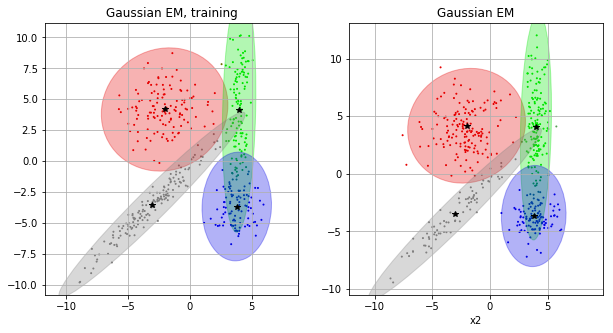

In [91]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
pi, mu, var, llc = em_train(data, K, vis="never", max_iter=50, isotropic=False)
colors = np.array([(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.5, 0.5, 0.5)], dtype=float)
plot_em(data, pi, mu, var, colors)
plt.title("Gaussian EM, training")

plt.subplot(122)
Ytest = em_fit(test, pi, mu, var)
plot_em(test, pi, mu, var, colors)
plt.title("Gaussian EM")
plt.xlabel("x1")
plt.xlabel("x2")
plt.show()

## Gaussian HMM

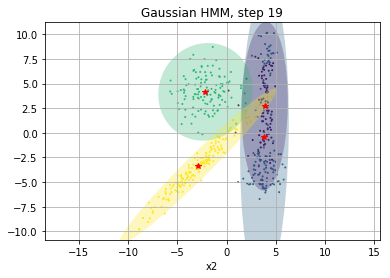

In [93]:
from hmm import GaussianHiddenMarkovModel

transition_proba = (0.95-0.05*K)*np.eye(K) + 0.05*np.ones((K, K))
# transition_proba = (1/K)*np.ones((K, K))
hmm = GaussianHiddenMarkovModel(pi, transition_proba, mu, var)
posteriors = hmm.fit(data, plotting="all", n_iter=20)

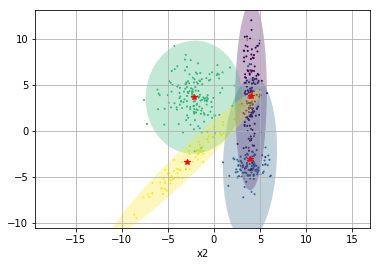

In [97]:
hmm.n = 0 
posteriors = hmm.fit(test, plotting="all", n_iter=20)